<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v1/blob/main/Rough_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
from scipy.optimize import newton

def calculate_xirr(dates, cash_flows):
    def xnpv(rate):
        return sum(cf / ((1 + rate) ** ((date - dates[0]).days / 365)) for date, cf in zip(dates, cash_flows))
    return newton(xnpv, 0.1)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myInvestments.csv')
df['Date'] = pd.to_datetime(df['Date'], format="%d-%b-%y")

# Extract inputs
dates = list(df['Date'])
cash_flows = list(df['Investment'])

# Define corpus
today = pd.to_datetime('30-Aug-2026', format="%d-%b-%Y") #pd.to_datetime(datetime.today().date())
corpus_value = 17250000  # Replace with actual

# Append current corpus
dates_with_corpus = dates + [today]
cash_flows_with_corpus = cash_flows + [corpus_value]

# XIRR calculation
xirr_with_corpus = calculate_xirr(dates_with_corpus, cash_flows_with_corpus)

# Absolute return
total_investment = -sum([cf for cf in cash_flows])
absolute_return = corpus_value - total_investment
absolute_return_pct = (absolute_return / total_investment) * 100

# Results
print(f"📊 Total Investment ₹{total_investment}")
print(f"📊 XIRR with current corpus ₹{corpus_value} ({xirr_with_corpus * 100:.2f}%)")
print(f"📈 Absolute Return: ₹{absolute_return} ({absolute_return_pct:.2f}%)")

📊 Total Investment ₹11654190
📊 XIRR with current corpus ₹17250000 (15.54%)
📈 Absolute Return: ₹5595810 (48.02%)


In [ ]:
import yfinance as yf
import pandas as pd

def backtest_52w_low_to_ath(ticker: str, start='2010-01-01') -> pd.DataFrame:
    data = yf.download(ticker + '.NS', start=start)
    data = data[['Close']].dropna()
    data['52w_low'] = data['Close'].rolling(window=252).min()
    data['ATH'] = data['Close'].cummax()
    data.dropna(inplace=True)

    trades = []
    in_position = False
    i = 252  # start after 1 year of data for 52w low

    while i < len(data):
        if not in_position:
            # Buy signal: Price hits 52-week low
            # Ensure comparison is between single values
            close_price = data['Close'].iloc[i]
            low_52w = data['52w_low'].iloc[i]

            # Check if low_52w is a Series and extract the single value
            if isinstance(low_52w, pd.Series):
                if len(low_52w) == 1:
                    low_52w = low_52w.item()
                else:
                    # Handle cases where it might be a Series with multiple values (unexpected here)
                    # For this specific context, we expect a single value.
                    # If this happens, there might be an issue with the rolling window calculation or data.
                    # For now, we'll take the first element as a potential workaround.
                    low_52w = low_52w.iloc[0]


            if close_price.iloc[0] <= low_52w:
                buy_date = data.index[i]
                buy_price = data['Close'].iloc[i].iloc[0]
                in_position = True

                # Search for next ATH after buy
                j = i + 1
                while j < len(data):
                    ath_value = data['ATH'].iloc[j]
                    if isinstance(ath_value, pd.Series):
                        if len(ath_value) == 1:
                            ath_value = ath_value.item()
                        else:
                            ath_value = ath_value.iloc[0]

                    if data['Close'].iloc[j].iloc[0] >= ath_value:
                        sell_date = data.index[j]
                        sell_price = data['Close'].iloc[j].iloc[0]
                        days_held = (sell_date - buy_date).days
                        profit_pct = ((sell_price - buy_price) / buy_price) * 100

                        trades.append({
                            'Buy Date': buy_date,
                            'Buy Price': round(buy_price, 2),
                            'Sell Date': sell_date,
                            'Sell Price': round(sell_price, 2),
                            'Days Held': days_held,
                            'Profit %': round(profit_pct, 2)
                        })
                        in_position = False
                        i = j  # jump to sell point
                        break
                    j += 1
        i += 1

    return pd.DataFrame(trades)

df = backtest_52w_low_to_ath("BHARTIARTL")
df

[*********************100%***********************]  1 of 1 completed


,Buy Date,Buy Price,Sell Date,Sell Price,Days Held,Profit %
0,2012-04-16,267.03,2015-06-19,371.51,1159,39.13
1,2015-08-26,291.99,2017-10-16,392.73,782,34.50
2,2018-05-23,311.13,2020-01-17,482.00,604,54.92


In [ ]:
# Gold price in 2000 and 2025
start_value = 4400
end_value = 80000
years = 2025 - 2000

# CAGR formula
cagr = ((end_value / start_value) ** (1 / years)) - 1
cagr_percentage = cagr * 100

round(cagr_percentage, 2)

12.3

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6181aa0060fd67d006f8a396c1ee89927bec092a8cda153a852098fda5766c89
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


[*********************100%***********************]  8 of 8 completed


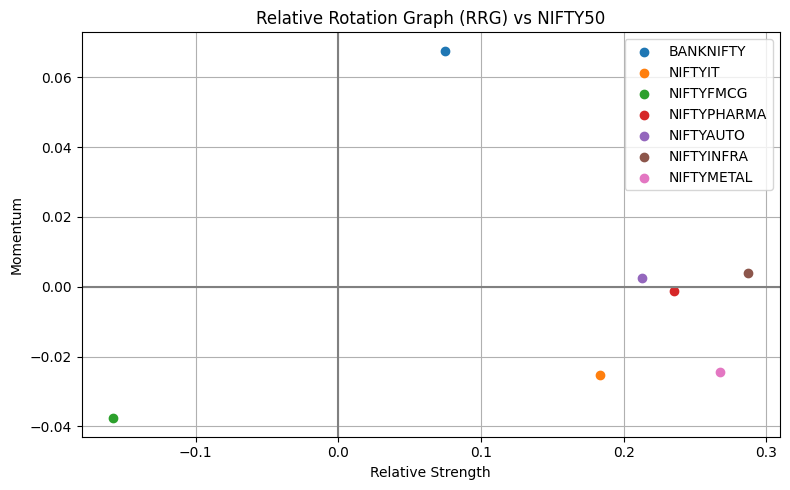

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Define tickers
tickers = {
    "NIFTY50": "^NSEI",
    "BANKNIFTY": "^NSEBANK",
    "NIFTYIT": "^CNXIT",
    "NIFTYFMCG": "^CNXFMCG",
    "NIFTYPHARMA": "^CNXPHARMA",
    "NIFTYAUTO": "^CNXAUTO",
    "NIFTYINFRA": "^CNXINFRA",
    "NIFTYMETAL": "^CNXMETAL"
}

# Download data
data = yf.download(list(tickers.values()), start="2024-01-01", end="2025-06-27")['Close']
data.columns = tickers.keys()

# Daily returns
returns = data.pct_change().dropna()

# Relative returns to NIFTY50
relative_returns = returns.div(returns["NIFTY50"], axis=0)

# Rolling mean and momentum
relative_strength = relative_returns.rolling(window=14).mean()
momentum = relative_strength.diff()

# Normalize
scaler = StandardScaler()
rs_scaled = scaler.fit_transform(relative_strength.drop(columns="NIFTY50").dropna())
mo_scaled = scaler.fit_transform(momentum.drop(columns="NIFTY50").dropna())

# Latest values
x = rs_scaled[-1]
y = mo_scaled[-1]
labels = relative_strength.columns.drop("NIFTY50")

# Plot RRG
plt.figure(figsize=(8, 5))
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

for i, label in enumerate(labels):
    plt.scatter(x[i], y[i], label=label)
    #plt.text(x[i] + 0.02, y[i] + 0.02, label, fontsize=12)

plt.title("Relative Rotation Graph (RRG) vs NIFTY50")
plt.xlabel("Relative Strength")
plt.ylabel("Momentum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[*********************100%***********************]  11 of 11 completed


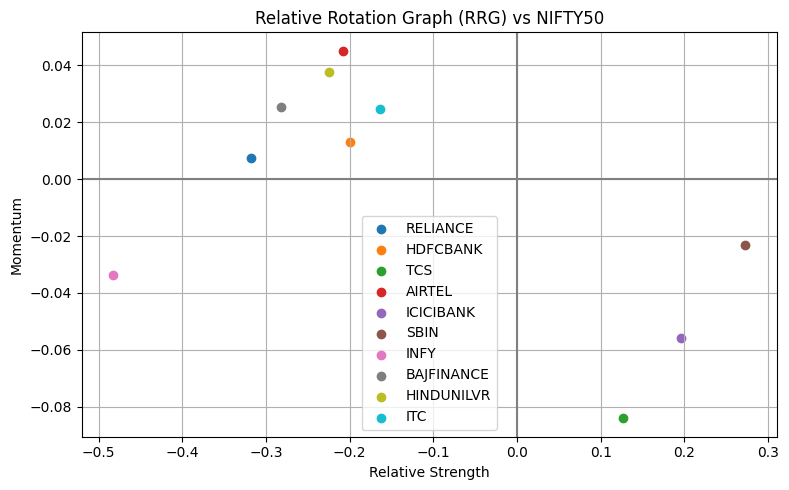

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

index = 'NIFTY50'

# Define tickers
tickers = {
    "NIFTY50": "^NSEI",
    "RELIANCE": "RELIANCE.NS",
    "HDFCBANK": "HDFCBANK.NS",
    "TCS": "TCS.NS",
    "AIRTEL": "BHARTIARTL.NS",
    "ICICIBANK": "ICICIBANK.NS",
    "SBIN": "SBIN.NS",
    "INFY": "INFY.NS",
    "BAJFINANCE": "BAJFINANCE.NS",
    "HINDUNILVR": "HINDUNILVR.NS",
    "ITC": "ITC.NS"
}

# Download data
data = yf.download(list(tickers.values()), start="2024-01-01", end="2025-06-28")['Close']
data.columns = tickers.keys()

# Daily returns
returns = data.pct_change().dropna()

# Relative returns to NIFTY50
relative_returns = returns.div(returns[index], axis=0)

# Rolling mean and momentum
relative_strength = relative_returns.rolling(window=14).mean()
momentum = relative_strength.diff()

# Normalize
scaler = StandardScaler()
rs_scaled = scaler.fit_transform(relative_strength.drop(columns=index).dropna())
mo_scaled = scaler.fit_transform(momentum.drop(columns=index).dropna())

# Latest values
x = rs_scaled[-1]
y = mo_scaled[-1]
labels = relative_strength.columns.drop(index)

# Plot RRG
plt.figure(figsize=(8, 5))
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

for i, label in enumerate(labels):
    plt.scatter(x[i], y[i], label=label)
    #plt.text(x[i] + 0.02, y[i] + 0.02, label, fontsize=12)

plt.title("Relative Rotation Graph (RRG) vs "+ index)
plt.xlabel("Relative Strength")
plt.ylabel("Momentum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


['SUNPHARMA', 'DRREDDY', 'CIPLA', 'DIVISLAB', 'LUPIN', 'AUROPHARMA', 'TORNTPHARM']


[*********************100%***********************]  8 of 8 completed


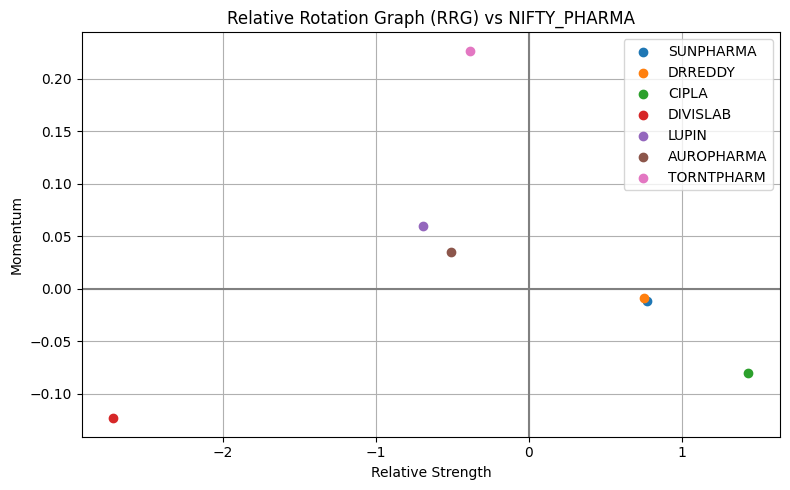

In [ ]:
# function to fetch my prospects csv
def get_mysector_df():
  mysector_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/NSE_Sectors_Indices.csv')
  return mysector_df

sector_key_item = 'PHARMA'
sector_value_item = '^CNXPHARMA'

df = get_mysector_df()
stock_key_list = df[df['Sector'] == sector_key_item]['Symbol']
stock_key_list = list(stock_key_list)
suffix = ".NS"
stock_value_list = list(stock_key_list)

# 1. Suffix each item except the first
for i in range(0, len(stock_value_list)):
    stock_value_list[i] = stock_value_list[i] + suffix

print(stock_key_list)
# 2. Add the new item to the list
stock_key_list.append(sector_key_item)
stock_value_list.append(sector_value_item)

# Download data
data = yf.download(list(stock_value_list), start="2024-01-01", end="2025-06-28")['Close']
data.columns = stock_key_list

# Daily returns
returns = data.pct_change().dropna()

# Relative returns to NIFTY50
relative_returns = returns.div(returns[sector_key_item], axis=0)

# Rolling mean and momentum
relative_strength = relative_returns.rolling(window=14).mean()
momentum = relative_strength.diff()

# Normalize
scaler = StandardScaler()
rs_scaled = scaler.fit_transform(relative_strength.drop(columns=sector_key_item).dropna())
mo_scaled = scaler.fit_transform(momentum.drop(columns=sector_key_item).dropna())

# Latest values
x = rs_scaled[-1]
y = mo_scaled[-1]
labels = relative_strength.columns.drop(sector_key_item)

# Plot RRG
plt.figure(figsize=(8, 5))
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

for i, label in enumerate(labels):
    plt.scatter(x[i], y[i], label=label)
    #plt.text(x[i] + 0.02, y[i] + 0.02, label, fontsize=12)

plt.title("Relative Rotation Graph (RRG) vs NIFTY_" + sector_key_item)
plt.xlabel("Relative Strength")
plt.ylabel("Momentum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# function to fetch screener data
def get_myscreen_df():
  myscreen_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myScreenerDB.csv')
  return myscreen_df
cols = ['Symbol', 'ATH%', 'PE', 'EPS', 'PB', 'MCap', 'ROCE%', 'ROE%',
       'Sales_Grwth%', 'Profit_Grwth%', 'MedPE',
       'Debt2EqR', 'PAT_12M', 'CFO_2_EBITDA%']
df = get_myscreen_df()[cols]

,Symbol,ATH%,PE,EPS,PB,MCap,ROCE%,ROE%,Sales_Grwth%,Profit_Grwth%,MedPE,Debt2EqR,PAT_12M,CFO_2_EBITDA%
0,RELIANCE,11.46,28.04,51.47,2.32,1953073.38,9.43,8.51,7.30,-0.21,26.59,0.44,81309.00,97.43
1,HDFCBANK,0.89,21.40,92.51,2.92,1514843.75,7.51,14.53,18.59,10.78,20.29,6.46,73440.17,45.42
2,TCS,35.70,25.23,134.20,12.92,1224124.52,64.63,52.38,5.99,4.14,31.12,0.10,48797.00,68.57
3,BHARTIARTL,2.50,40.45,58.85,9.38,1121650.12,15.36,28.34,15.34,132.81,65.71,1.88,37481.30,99.89
4,ICICIBANK,0.82,20.40,71.65,3.33,1041179.25,7.88,17.97,16.81,15.33,20.30,5.97,54569.38,75.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,SURYODAY,149.14,6.01,19.73,0.71,1260.62,8.49,12.74,10.44,6.82,4.56,19.02,209.59,96.83
735,5PAISA,106.33,18.76,19.61,2.00,1148.55,12.89,10.29,39.09,9.46,8.32,36.50,61.22,-85.27
736,VALIANTORG,623.61,NaN,-10.20,1.06,761.26,1.07,-0.91,20.45,21.02,16.03,NaN,-27.82,184.05
737,ASIANTILES,744.91,382.70,0.49,0.53,677.37,1.23,-0.91,24.18,5.57,1.80,NaN,-1.35,-125.63


In [39]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def are_smas_tightly_clustered(symbol: str, threshold_percent: float = 3.0):
    data = yf.download(symbol + '.NS', period='250d', progress=False)
    if data.empty:
        return {"symbol": symbol, "spread_%": None, "error": "No data"}

    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()


    try:
        latest = data.dropna().iloc[-1]
        sma_20 = latest['SMA_20']
        sma_50 = latest['SMA_50']
        sma_200 = latest['SMA_200']
        price = latest['Close']

        # Calculate spreads
        max_sma = max(sma_20.item(), sma_50.item(), sma_200.item())
        min_sma = min(sma_20.item(), sma_50.item(), sma_200.item())
        abs_spread = max_sma - min_sma
        pct_spread = (abs_spread / sma_200) * 100

        return {
            "Symbol": symbol,
            "Spread_%": round(pct_spread[0], 2)
        }
    except:
        return {"Symbol": symbol, "Spread_%": None, "Error": "Insufficient data"}

# ✅ Function to loop through multiple scrips
def check_multiple_scrips(scrip_list, threshold=3.0):
    results = []
    for scrip in scrip_list:
        result = are_smas_tightly_clustered(scrip, threshold_percent=threshold)
        print(result["Spread_%"])
        results.append(result)
    return pd.DataFrame(results)

# 🧪 Example usage
scrips = ["RELIANCE", "TCS", "INFY", "HDFCBANK", "BAJAJFINSV"]
df_result = check_multiple_scrips(scrips)
df_result


12.35
10.06
8.21
10.5
9.18


,Symbol,Spread_%
0,RELIANCE,12.35
1,TCS,10.06
2,INFY,8.21
3,HDFCBANK,10.50
4,BAJAJFINSV,9.18
